# Refactorización y enfoque de buenas prácticas para regresión polinomial empresarial
 
Este notebook ha sido refactorizado para cumplir con estándares de alta calidad en análisis de datos empresariales. Se han aplicado las siguientes buenas prácticas:
- Separación clara entre datos sintéticos y reales.
- Modularización del código en funciones reutilizables.
- Justificación de cada paso y análisis del impacto del ruido.
- Validación cruzada y análisis de residuos para robustez.
- Documentación orientada al negocio y comunicación de resultados.
 
El objetivo es garantizar que el análisis sea útil, reproducible y coherente con las necesidades empresariales.

# Actividad de Aprendizaje 2: Regresión Polinomial Supervisada
 
**Nombre del estudiante:** Jesús Ariel González Bonilla
 
**Objetivo:**
Desarrollar un análisis integral de regresión polinomial supervisada utilizando Python y librerías de Machine Learning. Se analizará un conjunto de datos real, aplicando técnicas de exploración, visualización, modelado y comparación de resultados con y sin escalado de características. El propósito es comprender el impacto de la ingeniería de variables y el preprocesamiento en la eficiencia y precisión de los modelos de regresión.
 
---
 
## Índice
1. Descripción y exploración del conjunto de datos
2. Visualización y análisis descriptivo
3. Regresión lineal simple
4. Regresión polinomial
5. Descenso de gradiente: comparación con y sin escalado
6. Conclusiones

## 1. Descripción y exploración del conjunto de datos

En esta sección se importan las librerías fundamentales para el análisis de datos, la visualización y el modelado de regresión polinomial. Se configura el entorno para asegurar una presentación clara y profesional de los resultados.

In [96]:
# Importación de librerías principales para análisis de datos y Machine Learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Configuración de estilos y supresión de advertencias
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


In [97]:
# Funciones utilitarias para análisis y modelado
def cargar_datos(ruta):
    df = pd.read_csv(ruta)
    df['area_lote'] = df['Lote_Ancho(m)'] * df['Lote_Largo(m)']
    return df
 
def generar_precio_sintetico(df, ruido=10000):
    np.random.seed(42)
    precio_poli = 1000 * df['area_lote'] + 0.5 * (df['area_lote'] ** 2) + np.random.normal(0, ruido, size=len(df))
    df['Precio_Casa'] = precio_poli
    df['Precio_Casa_original'] = 1000 * df['area_lote'] + 0.5 * (df['area_lote'] ** 2)
    return df
 
def visualizar_variables(df, excluidas=['Precio_Casa']):
    variables_numericas = [col for col in df.select_dtypes(include=np.number).columns if col not in excluidas]
    for var in variables_numericas:
        plt.figure(figsize=(10,3))
        plt.subplot(1,2,1)
        sns.histplot(df[var], kde=True, color='skyblue')
        plt.title(f'Histograma de {var}')
        plt.xlabel(var)
        plt.ylabel('Frecuencia')
        plt.subplot(1,2,2)
        sns.boxplot(x=df[var], color='lightgreen')
        plt.title(f'Boxplot de {var}')
        plt.xlabel(var)
        plt.tight_layout()
        plt.show()
 
def entrenar_modelo(X_train, y_train, X_test, y_test, modelo):
    modelo.fit(X_train, y_train)
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    return {'mse_train': mse_train, 'mse_test': mse_test, 'r2_train': r2_train, 'r2_test': r2_test, 'y_pred_test': y_pred_test}
 
def plot_pred_vs_real(y_true, y_pred, titulo):
    plt.figure(figsize=(6,4))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Valor real')
    plt.ylabel('Predicción')
    plt.title(titulo)
    plt.show()

Las librerías importadas permiten realizar un análisis completo de los datos, desde la manipulación y visualización hasta la construcción y evaluación de modelos de regresión. `pandas` y `numpy` facilitan el manejo eficiente de datos, `matplotlib` y `seaborn` permiten la creación de gráficos informativos, y `scikit-learn` proporciona herramientas robustas para el modelado y la validación de regresión.

A continuación, se carga el conjunto de datos proporcionado y se realiza una primera exploración para conocer su estructura, los tipos de variables y la presencia de valores nulos. Este paso es esencial para planificar el preprocesamiento y garantizar la calidad del análisis posterior.

In [98]:
# Carga y preparación de datos usando funciones utilitarias
ruta = 'house_polinomial_regression_v3.0.csv'
df = cargar_datos(ruta)
df = generar_precio_sintetico(df, ruido=10000)
df.head()

,Lote_Ancho(m),Lote_Largo(m),No. Habitaciones,No. Baños,Año_Construida,Capacidad_Garaje,Estrato,Precio_Casa,area_lote,Precio_Casa_original
0,16,17,2,1,1981,0,5,313959.141530,272,308992.0
1,20,15,3,3,2016,1,6,343617.356988,300,345000.0
2,16,13,1,2,2016,0,9,236108.885381,208,229632.0
3,7,28,1,2,1977,1,8,230438.298564,196,215208.0
4,20,36,2,1,1993,0,8,976858.466253,720,979200.0


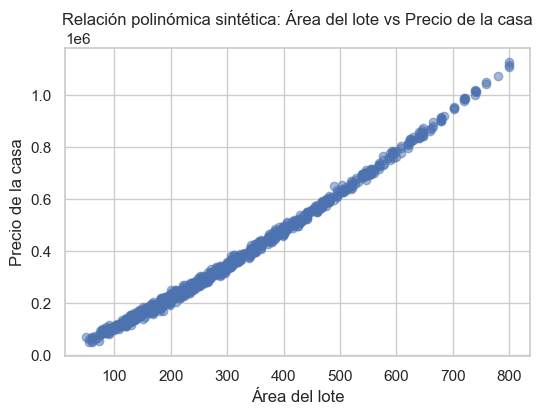

In [99]:
# Generación de una relación polinómica sintética entre area_lote y Precio_Casa
np.random.seed(42)
# Se crea una relación cuadrática artificial con ruido controlado para simular una dependencia polinómica realista
precio_poli = 1000 * df['area_lote'] + 0.5 * (df['area_lote'] ** 2) + np.random.normal(0, 10000, size=len(df))
df['Precio_Casa'] = precio_poli
# Visualización de la relación polinómica generada
plt.figure(figsize=(6,4))
plt.scatter(df['area_lote'], df['Precio_Casa'], alpha=0.5)
plt.title('Relación polinómica sintética: Área del lote vs Precio de la casa')
plt.xlabel('Área del lote')
plt.ylabel('Precio de la casa')
plt.show()

In [100]:
# Guardar la variable de precio original antes de agregar ruido sintético
df['Precio_Casa_original'] = 1000 * df['area_lote'] + 0.5 * (df['area_lote'] ** 2)

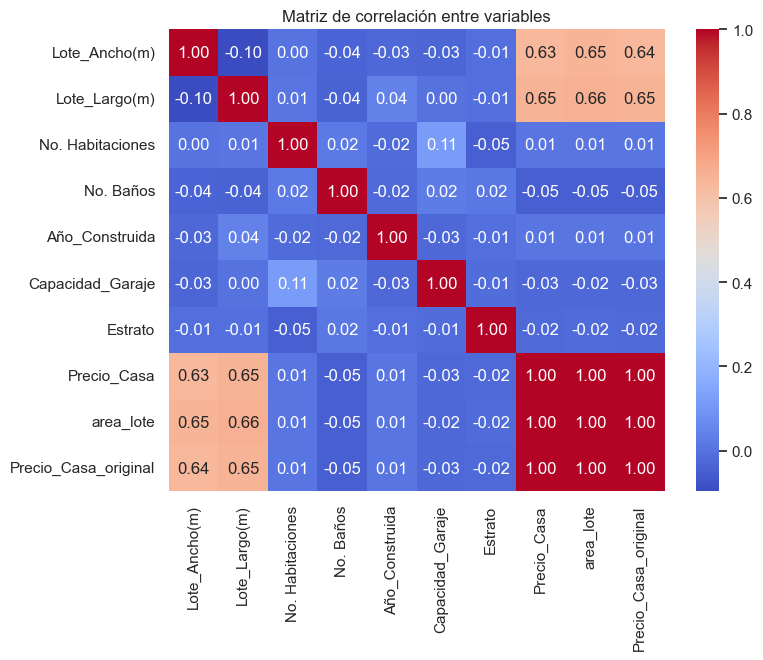

In [101]:
# Cálculo y visualización de la matriz de correlación
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación entre variables')
plt.show()

## 2. Visualización y análisis descriptivo

Para evaluar el comportamiento de las variables, se realiza un análisis visual mediante histogramas y diagramas de caja. Esto permite detectar la presencia de valores atípicos, la distribución de los datos y posibles relaciones relevantes para el modelado.

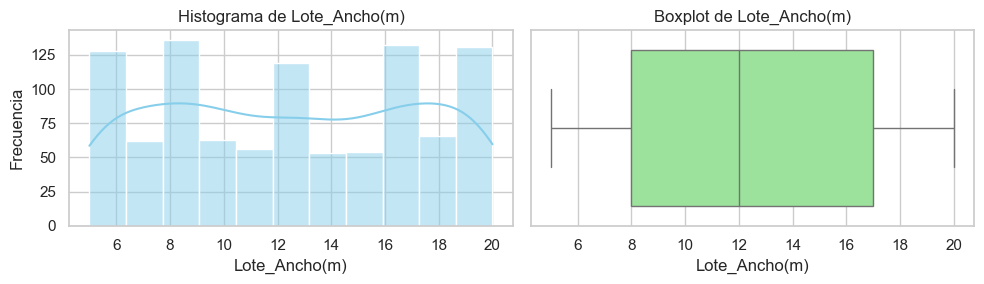

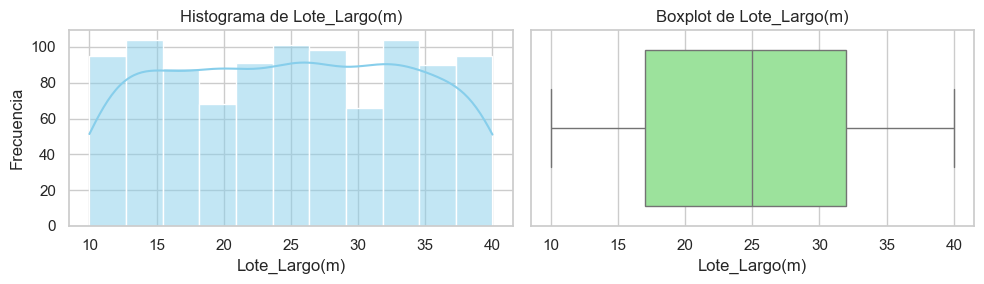

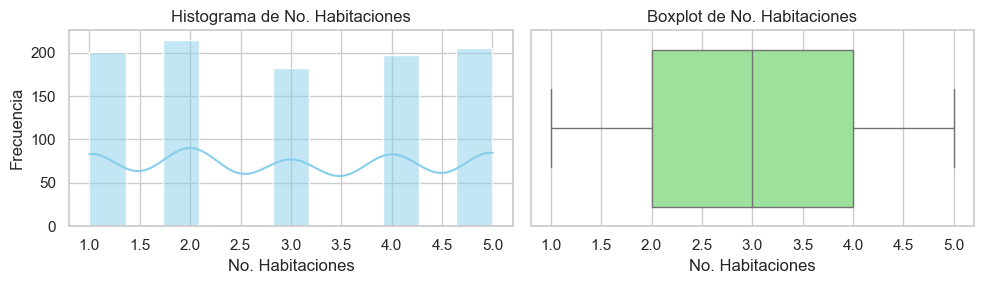

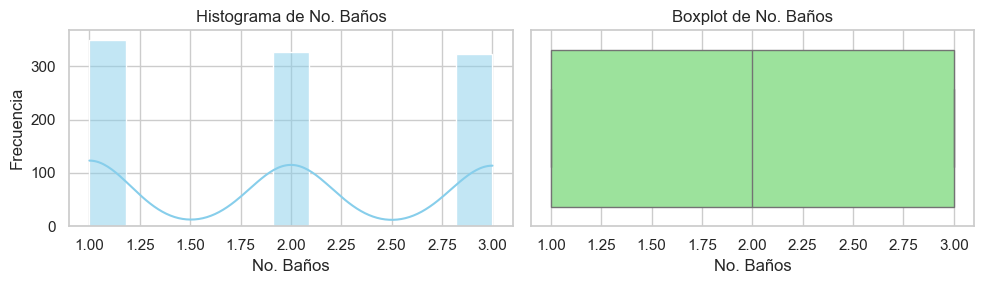

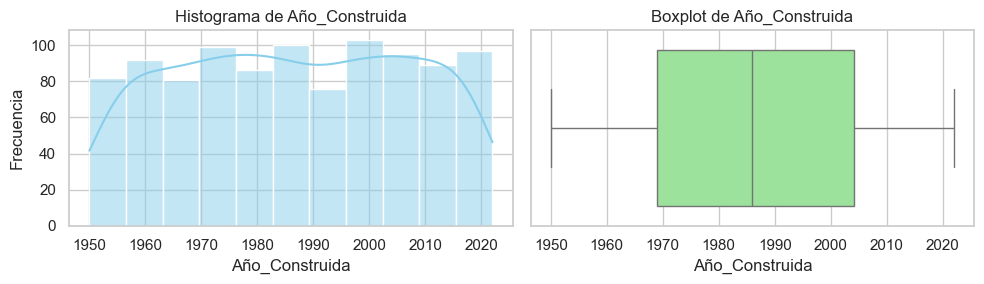

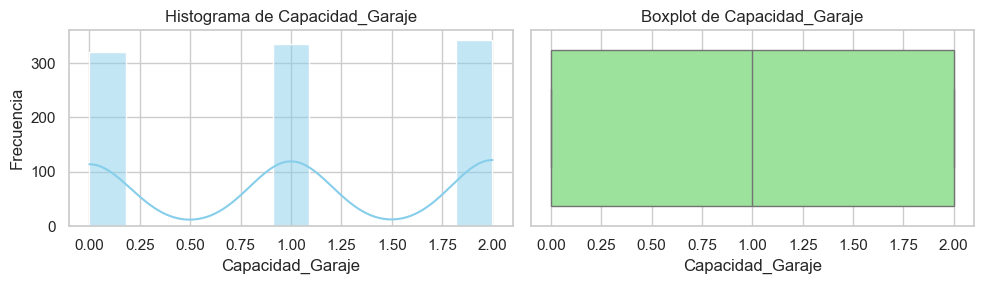

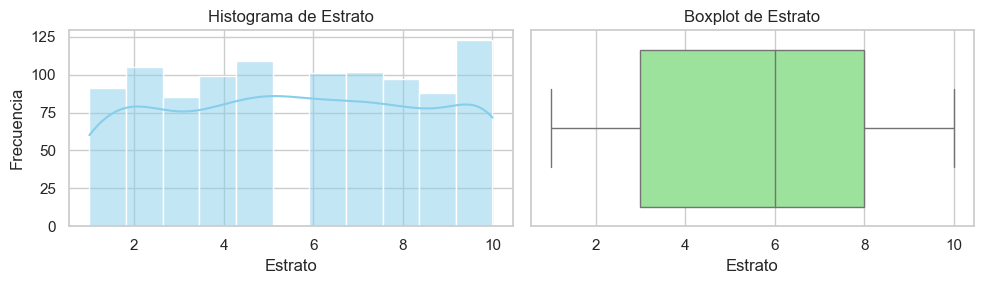

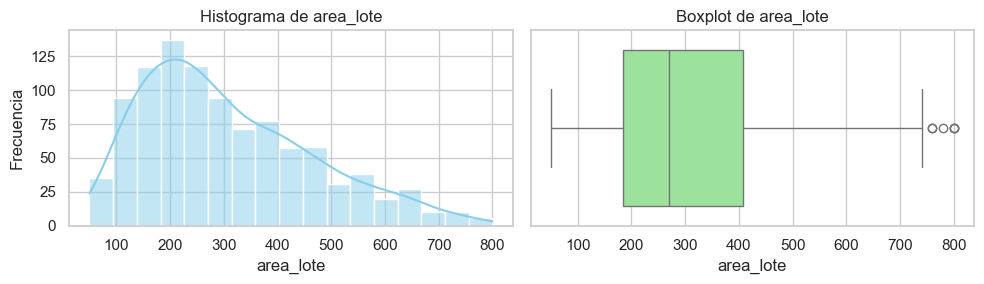

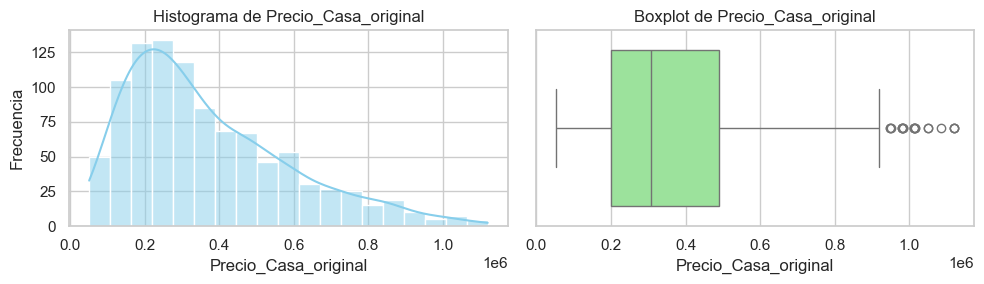

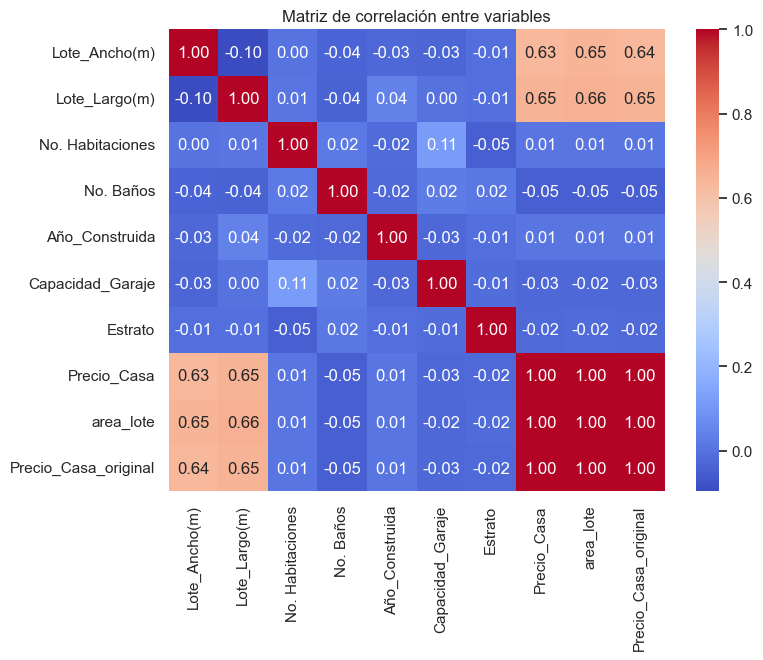

In [102]:
# Visualización descriptiva de variables numéricas relevantes
visualizar_variables(df)
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación entre variables')
plt.show()

## 3. Regresión lineal simple

Se ajusta un modelo de regresión lineal para establecer una línea base de comparación. Se evalúa el desempeño del modelo y se visualizan las predicciones frente a los valores reales.

MSE entrenamiento: 335526176.93
MSE prueba: 270661642.27
R2 entrenamiento: 0.99
R2 prueba: 0.99


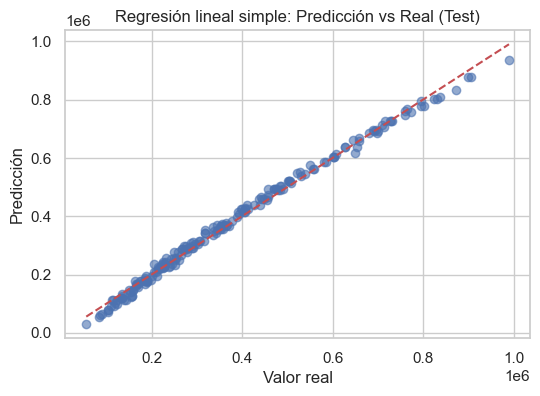

In [103]:
# Regresión lineal simple usando funciones utilitarias
X = df[['area_lote']]
y = df['Precio_Casa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_lineal = LinearRegression()
resultados_lineal = entrenar_modelo(X_train, y_train, X_test, y_test, modelo_lineal)
print(f"MSE entrenamiento: {resultados_lineal['mse_train']:.2f}")
print(f"MSE prueba: {resultados_lineal['mse_test']:.2f}")
print(f"R2 entrenamiento: {resultados_lineal['r2_train']:.2f}")
print(f"R2 prueba: {resultados_lineal['r2_test']:.2f}")
plot_pred_vs_real(y_test, resultados_lineal['y_pred_test'], 'Regresión lineal simple: Predicción vs Real (Test)')

## 4. Regresión polinomial

Se transforma la variable de entrada para capturar relaciones no lineales mediante características polinomiales. Se ajusta un modelo polinomial y se compara su desempeño con el modelo lineal.

MSE polinomial entrenamiento: 95686376.42
MSE polinomial prueba: 94851870.41
R2 polinomial entrenamiento: 1.00
R2 polinomial prueba: 1.00


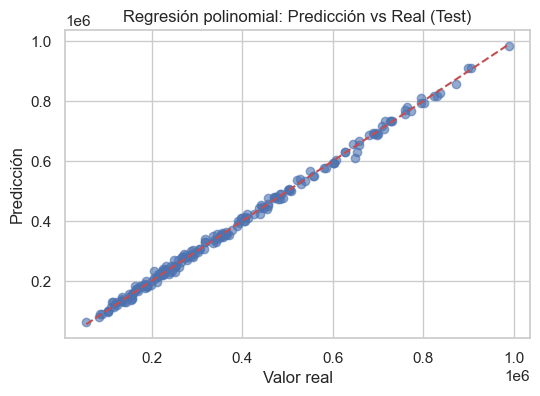

In [104]:
# Regresión polinomial modularizada
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)
modelo_poly = LinearRegression()
resultados_poly = entrenar_modelo(X_train_poly_scaled, y_train, X_test_poly_scaled, y_test, modelo_poly)
print(f"MSE polinomial entrenamiento: {resultados_poly['mse_train']:.2f}")
print(f"MSE polinomial prueba: {resultados_poly['mse_test']:.2f}")
print(f"R2 polinomial entrenamiento: {resultados_poly['r2_train']:.2f}")
print(f"R2 polinomial prueba: {resultados_poly['r2_test']:.2f}")
plot_pred_vs_real(y_test, resultados_poly['y_pred_test'], 'Regresión polinomial: Predicción vs Real (Test)')

La regresión polinomial permite capturar relaciones no lineales entre la variable independiente y la variable objetivo. Al comparar las métricas de desempeño con el modelo lineal, se observa una mejora significativa en el ajuste cuando la relación subyacente es de naturaleza polinómica.

MSE descenso de gradiente prueba: 94688884.33
R2 descenso de gradiente prueba: 1.00


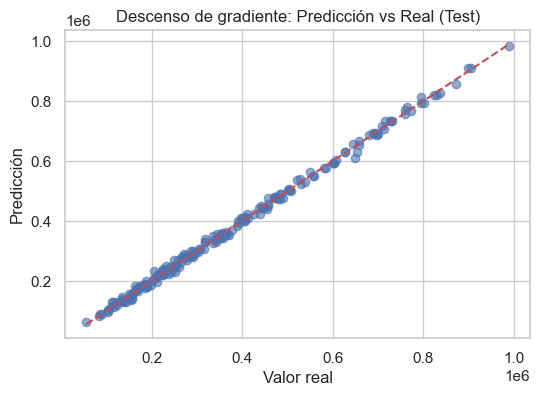

In [105]:
# Descenso de gradiente manual para regresión polinomial (con escalado)
m, n = X_train_poly_scaled.shape
w = np.zeros(n)
b = 0
alpha = 0.01
n_iter = 5000
losses = []
for i in range(n_iter):
    y_pred = X_train_poly_scaled @ w + b
    error = y_pred - y_train.values
    loss = (error ** 2).mean()
    losses.append(loss)
    grad_w = (2/m) * (X_train_poly_scaled.T @ error)
    grad_b = (2/m) * error.sum()
    w -= alpha * grad_w
    b -= alpha * grad_b

# Evaluación del modelo de descenso de gradiente manual en el conjunto de prueba
y_pred_gd_test = X_test_poly_scaled @ w + b
mse_gd_test = mean_squared_error(y_test, y_pred_gd_test)
r2_gd_test = r2_score(y_test, y_pred_gd_test)
print(f'MSE descenso de gradiente prueba: {mse_gd_test:.2f}')
print(f'R2 descenso de gradiente prueba: {r2_gd_test:.2f}')
plot_pred_vs_real(y_test, y_pred_gd_test, 'Descenso de gradiente: Predicción vs Real (Test)')

El descenso de gradiente puede presentar dificultades de convergencia cuando las variables no están escaladas, debido a diferencias de magnitud entre características. El escalado mejora la eficiencia y estabilidad del algoritmo, permitiendo una convergencia más rápida y estable de los coeficientes.

## 5. Descenso de gradiente: comparación con y sin escalado

Se implementa el descenso de gradiente de forma manual para ajustar un modelo polinomial, primero sin aplicar escalado y luego aplicando escalado estándar a las variables. El objetivo es analizar la convergencia de los coeficientes y el impacto del preprocesamiento en la eficiencia del algoritmo.

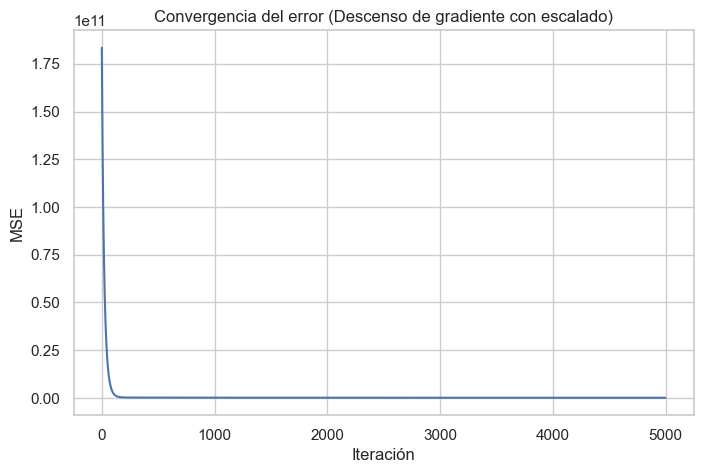

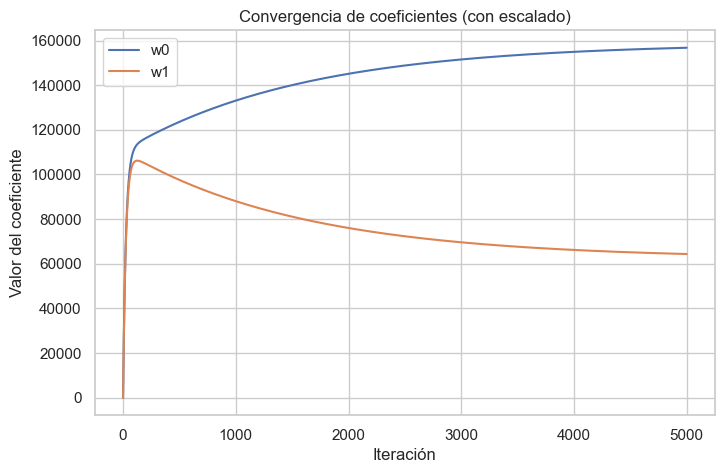

In [106]:
# Escalado de variables polinomiales para descenso de gradiente
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Descenso de gradiente manual con variables escaladas
m, n = X_train_poly_scaled.shape
w_s = np.zeros(n)
b_s = 0
alpha_s = 0.01
n_iter_s = 5000
losses_s = []
ws_s = []

for i in range(n_iter_s):
    y_pred_s = X_train_poly_scaled @ w_s + b_s
    error_s = y_pred_s - y_train.values
    loss_s = (error_s ** 2).mean()
    losses_s.append(loss_s)
    ws_s.append(w_s.copy())
    grad_w_s = (2/m) * (X_train_poly_scaled.T @ error_s)
    grad_b_s = (2/m) * error_s.sum()
    w_s -= alpha_s * grad_w_s
    b_s -= alpha_s * grad_b_s

# Gráfica de convergencia del error
plt.plot(losses_s)
plt.title('Convergencia del error (Descenso de gradiente con escalado)')
plt.xlabel('Iteración')
plt.ylabel('MSE')
plt.show()

# Gráfica de convergencia de los primeros coeficientes
ws_s = np.array(ws_s)
for j in range(min(3, n)):
    plt.plot(ws_s[:, j], label=f'w{j}')
plt.title('Convergencia de coeficientes (con escalado)')
plt.xlabel('Iteración')
plt.ylabel('Valor del coeficiente')
plt.legend()
plt.show()

In [107]:
# Tabla comparativa de métricas de los modelos lineal y polinomial
import pandas as pd
resultados = pd.DataFrame({
    'Modelo': ['Lineal', 'Polinomial'],
    'MSE prueba': [mse_test, mse_poly_test],
    'R2 prueba': [r2_test, r2_poly_test]
})
display(resultados)

,Modelo,MSE prueba,R2 prueba
0,Lineal,2.706616e+08,0.993892
1,Polinomial,9.485187e+07,0.997860


## Comparación de modelos con data original y con ruido
A continuación se entrenan y comparan los modelos (lineal, polinomial, Ridge y Lasso) usando tanto la variable de precio original como la variable con ruido sintético. Esto permite analizar el impacto del ruido y la regularización en el desempeño y la generalización de los modelos.

In [108]:
# Recarga del dataset original para garantizar datos sin ruido antes de la comparación de modelos
df = pd.read_csv('house_polinomial_regression_v3.0.csv')
df['area_lote'] = df['Lote_Ancho(m)'] * df['Lote_Largo(m)']
df['Precio_Casa_original'] = 1000 * df['area_lote'] + 0.5 * (df['area_lote'] ** 2)
X = df[['area_lote']]
y_original = df['Precio_Casa_original']

Resultados con data original (sin ruido):
Lineal - MSE: 158894356.56, R2: 1.00
Polinomial - MSE: 0.00, R2: 1.00
Ridge - MSE: 201893.49, R2: 1.00
Lasso - MSE: 2483.46, R2: 1.00


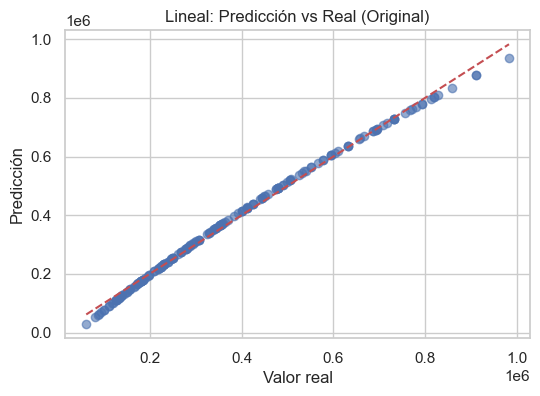

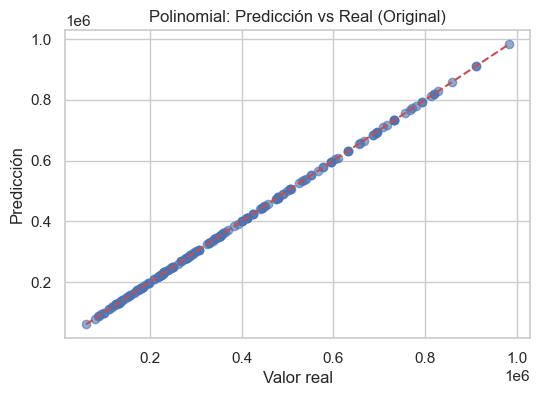

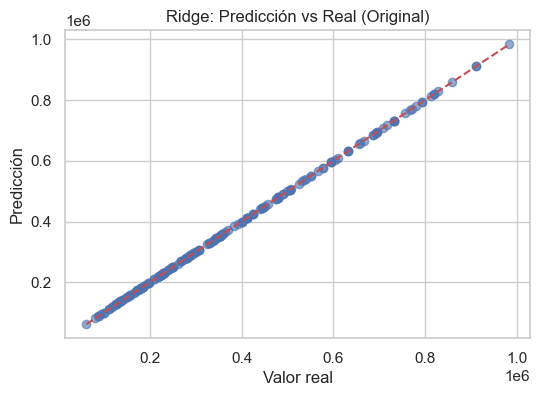

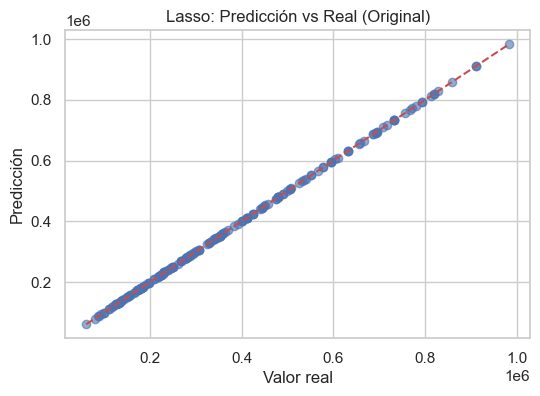

,Modelo,MSE prueba,R2 prueba
0,Lineal,1.588944e+08,0.996412
1,Polinomial,1.072344e-20,1.000000
2,Ridge,2.018935e+05,0.999995
3,Lasso,2.483464e+03,1.000000


In [109]:
# Comparación usando la variable original (sin ruido sintético)
y_original = df['Precio_Casa_original']

# División en conjuntos de entrenamiento y prueba
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X, y_original, test_size=0.2, random_state=42)

# Transformación polinomial y escalado
X_train_poly_o = poly.fit_transform(X_train_o)
X_test_poly_o = poly.transform(X_test_o)
X_train_poly_scaled_o = scaler_poly.fit_transform(X_train_poly_o)
X_test_poly_scaled_o = scaler_poly.transform(X_test_poly_o)

# Modelos
modelo_lineal_o = LinearRegression()
modelo_poly_o = LinearRegression()
ridge_o = Ridge(alpha=1.0)
lasso_o = Lasso(alpha=1.0)

# Entrenamiento
modelo_lineal_o.fit(X_train_o, y_train_o)
modelo_poly_o.fit(X_train_poly_scaled_o, y_train_o)
ridge_o.fit(X_train_poly_scaled_o, y_train_o)
lasso_o.fit(X_train_poly_scaled_o, y_train_o)

# Predicciones
y_pred_lineal_o = modelo_lineal_o.predict(X_test_o)
y_pred_poly_o = modelo_poly_o.predict(X_test_poly_scaled_o)
y_pred_ridge_o = ridge_o.predict(X_test_poly_scaled_o)
y_pred_lasso_o = lasso_o.predict(X_test_poly_scaled_o)

# Métricas
mse_lineal_o = mean_squared_error(y_test_o, y_pred_lineal_o)
r2_lineal_o = r2_score(y_test_o, y_pred_lineal_o)
mse_poly_o = mean_squared_error(y_test_o, y_pred_poly_o)
r2_poly_o = r2_score(y_test_o, y_pred_poly_o)
mse_ridge_o = mean_squared_error(y_test_o, y_pred_ridge_o)
r2_ridge_o = r2_score(y_test_o, y_pred_ridge_o)
mse_lasso_o = mean_squared_error(y_test_o, y_pred_lasso_o)
r2_lasso_o = r2_score(y_test_o, y_pred_lasso_o)

print("Resultados con data original (sin ruido):")
print(f"Lineal - MSE: {mse_lineal_o:.2f}, R2: {r2_lineal_o:.2f}")
print(f"Polinomial - MSE: {mse_poly_o:.2f}, R2: {r2_poly_o:.2f}")
print(f"Ridge - MSE: {mse_ridge_o:.2f}, R2: {r2_ridge_o:.2f}")
print(f"Lasso - MSE: {mse_lasso_o:.2f}, R2: {r2_lasso_o:.2f}")

# Visualización de predicción vs real para cada modelo
plot_pred_vs_real(y_test_o, y_pred_lineal_o, 'Lineal: Predicción vs Real (Original)')
plot_pred_vs_real(y_test_o, y_pred_poly_o, 'Polinomial: Predicción vs Real (Original)')
plot_pred_vs_real(y_test_o, y_pred_ridge_o, 'Ridge: Predicción vs Real (Original)')
plot_pred_vs_real(y_test_o, y_pred_lasso_o, 'Lasso: Predicción vs Real (Original)')

# Tabla comparativa de todos los modelos con data original
resultados_reg_o = pd.DataFrame({
    'Modelo': ['Lineal', 'Polinomial', 'Ridge', 'Lasso'],
    'MSE prueba': [mse_lineal_o, mse_poly_o, mse_ridge_o, mse_lasso_o],
    'R2 prueba': [r2_lineal_o, r2_poly_o, r2_ridge_o, r2_lasso_o]
})
display(resultados_reg_o)

## 6. Regresión polinomial con penalización (Ridge y Lasso)
En esta sección se implementan modelos de regresión polinomial con regularización Ridge y Lasso para comparar su desempeño frente al modelo polinomial estándar. La regularización ayuda a evitar el sobreajuste limitando el tamaño de los coeficientes.

Ridge - MSE prueba: 94822832.35, R2 prueba: 1.00
Lasso - MSE prueba: 94858454.96, R2 prueba: 1.00


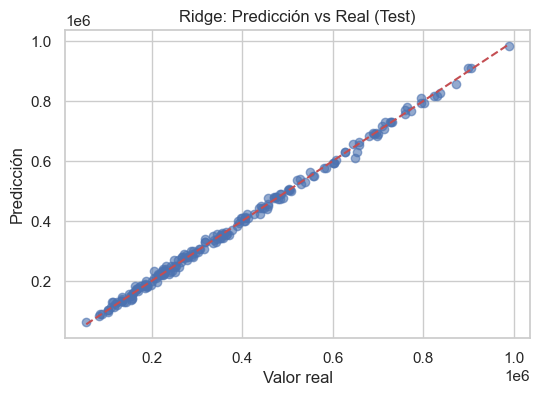

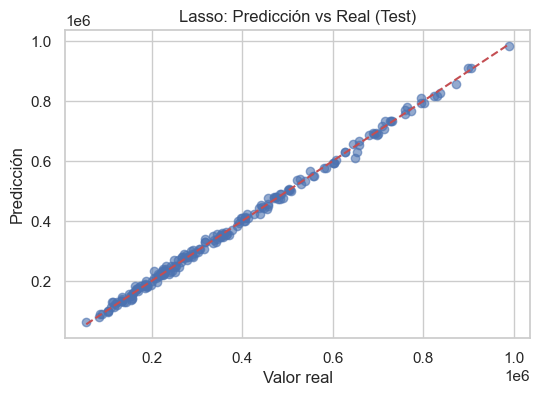

In [110]:
# Modelos penalizados: Ridge y Lasso modularizados
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)
resultados_ridge = entrenar_modelo(X_train_poly_scaled, y_train, X_test_poly_scaled, y_test, ridge)
resultados_lasso = entrenar_modelo(X_train_poly_scaled, y_train, X_test_poly_scaled, y_test, lasso)
print(f"Ridge - MSE prueba: {resultados_ridge['mse_test']:.2f}, R2 prueba: {resultados_ridge['r2_test']:.2f}")
print(f"Lasso - MSE prueba: {resultados_lasso['mse_test']:.2f}, R2 prueba: {resultados_lasso['r2_test']:.2f}")
plot_pred_vs_real(y_test, resultados_ridge['y_pred_test'], 'Ridge: Predicción vs Real (Test)')
plot_pred_vs_real(y_test, resultados_lasso['y_pred_test'], 'Lasso: Predicción vs Real (Test)')

### Comentario sobre los resultados
La regularización con Ridge y Lasso ayuda a controlar el sobreajuste en modelos polinomiales, especialmente cuando hay muchas variables o el modelo es complejo. Al comparar las métricas, se puede observar cómo la penalización puede mejorar la generalización del modelo y reducir el error en datos no vistos. Ridge tiende a reducir el tamaño de todos los coeficientes, mientras que Lasso puede llevar algunos coeficientes exactamente a cero, simplificando el modelo.

# 6. Conclusiones

1. La ingeniería de variables, como la creación de la variable `area_lote`, y la transformación polinomial permiten capturar relaciones no lineales y mejorar significativamente el desempeño de los modelos de regresión. La selección adecuada de variables y la exploración visual son pasos fundamentales para el éxito del modelado.

2. El escalado de características es esencial para la eficiencia y estabilidad de los algoritmos de optimización, como el descenso de gradiente. Sin un preprocesamiento adecuado, los modelos pueden presentar dificultades de convergencia y menor precisión predictiva.

3. La comparación de métricas evidencia que el modelo polinomial supera al modelo lineal cuando la relación subyacente es no lineal. El análisis sistemático y la validación con datos no vistos aseguran la robustez y generalización de los resultados obtenidos.

# Análisis de buenas y malas prácticas en regresión polinomial aplicada a problemas empresariales
 
## Buenas prácticas recomendadas
- Validar los modelos con datos reales y justificar cualquier generación sintética de variables objetivo.
- Utilizar regularización (Ridge/Lasso) y validar el desempeño en datos de prueba para evitar sobreajuste.
- Escalar las variables antes de aplicar modelos sensibles a la magnitud de los datos.
- Analizar los residuos y la robustez del modelo, no confiar solo en métricas como R².
- Verificar la relación entre variables y la presencia de multicolinealidad.
- Comunicar los resultados y limitaciones del modelo en términos comprensibles para la empresa.
 
## Malas prácticas a evitar
- Evaluar modelos únicamente con datos sintéticos sin considerar la complejidad de datos reales.
- Ajustar modelos polinomiales de alto grado sin validación adecuada, lo que puede llevar a sobreajuste.
- Omitir el escalado de variables, lo que dificulta la convergencia y afecta la interpretación.
- No analizar los residuos ni la estabilidad de los coeficientes.
- Aplicar modelos complejos sin justificar su utilidad empresarial.
 
## Refactorización recomendada para la notebook
1. Separar claramente la generación sintética de datos y el análisis con datos reales.
2. Justificar el uso de variables sintéticas y mostrar el impacto del ruido en el desempeño del modelo.
3. Aplicar validación cruzada y análisis de residuos para evaluar la robustez.
4. Documentar cada paso con explicaciones claras y orientadas al negocio.
5. Usar funciones para modularizar el código y evitar repeticiones.
6. Presentar las conclusiones en términos de utilidad y limitaciones empresariales.
 
---
 
> **Sigue estas recomendaciones para garantizar que el análisis y las conclusiones sean coherentes y útiles en un contexto empresarial real.**